## Filter Decomposition - Multi Output Regression Approach

### Importing Libraries

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from fimage import FImage
from fimage.filters import Contrast, Brightness, Saturation, Hue, Exposure, Sharpen, Sepia,  Vibrance, Noise

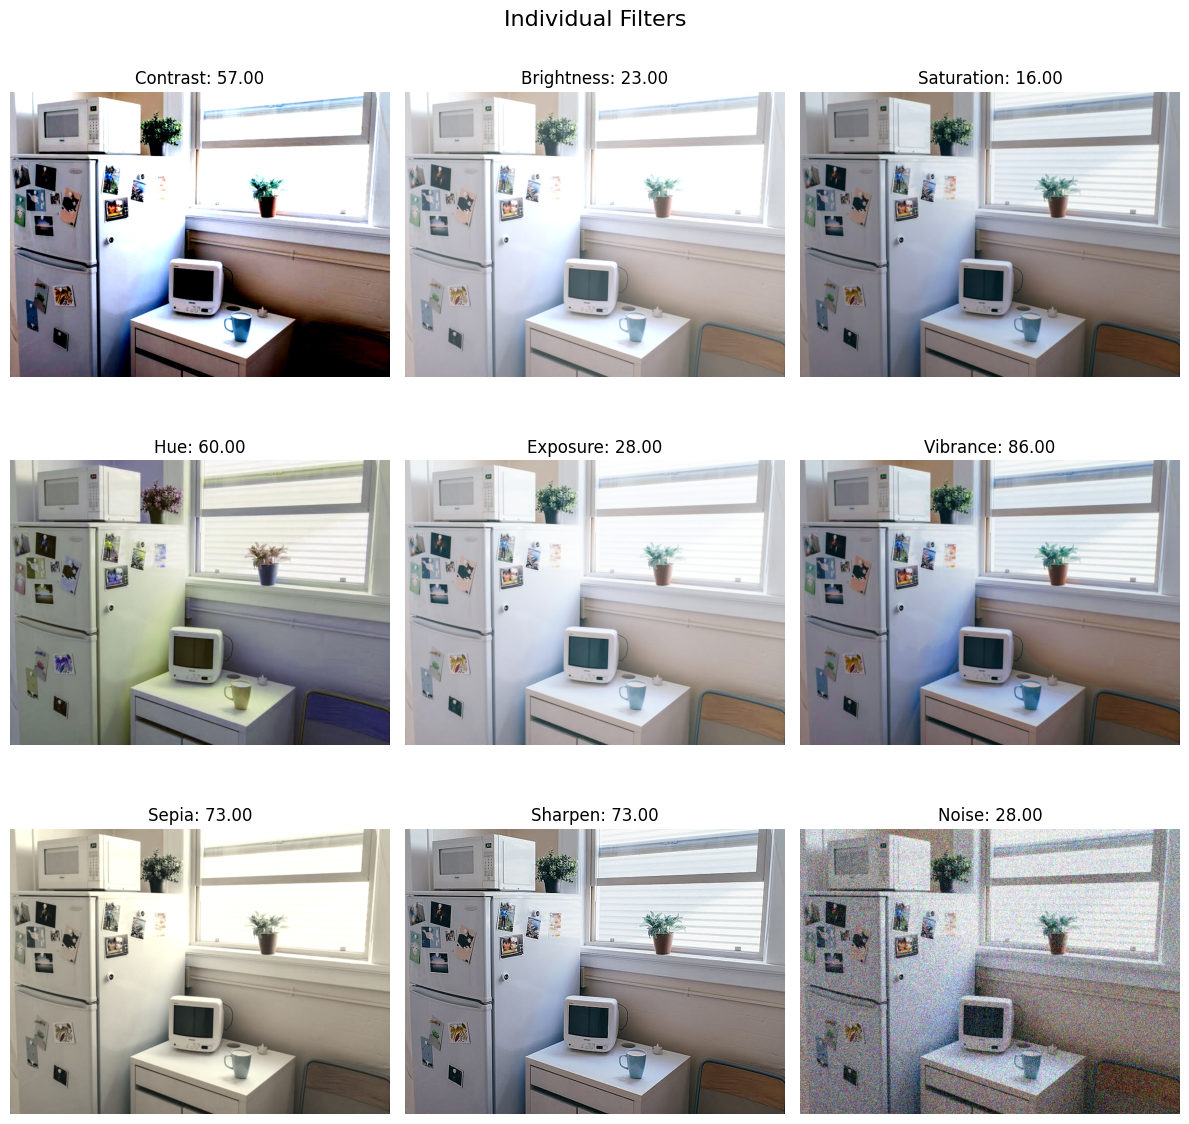

In [13]:
FILTERS = {
    'Contrast': (Contrast, (10, 75)),
    'Brightness': (Brightness, (5, 30)),
    'Saturation': (Saturation, (10, 100)),
    'Hue': (Hue, (0, 100)),
    'Exposure': (Exposure, (10, 30)),
    'Vibrance': (Vibrance, (20, 100)),
    'Sepia': (Sepia, (15, 100)),
    'Sharpen': (Sharpen, (10, 75)),
    'Noise': (Noise, (1, 30)),
}

def plot_filter_previews(image_path):
    # Create figure with 3x3 subplots
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.suptitle('Individual Filters', fontsize=16)
    
    for idx, (filta_name, (filta, (min_val, max_val))) in enumerate(FILTERS.items()):
        row = idx // 3
        col = idx % 3

        img = FImage(image_path)

        val = random.randint(min_val, max_val)
        img.apply(filta(val))
        
        # Display the image
        axes[row, col].imshow(img.image)
        axes[row, col].axis('off')
        axes[row, col].set_title(f'{filta_name}: {val:.2f}')
    
    plt.tight_layout()
    plt.show()

# Example usage with your image path
img_path = "test_image.jpg"
plot_filter_previews(img_path)

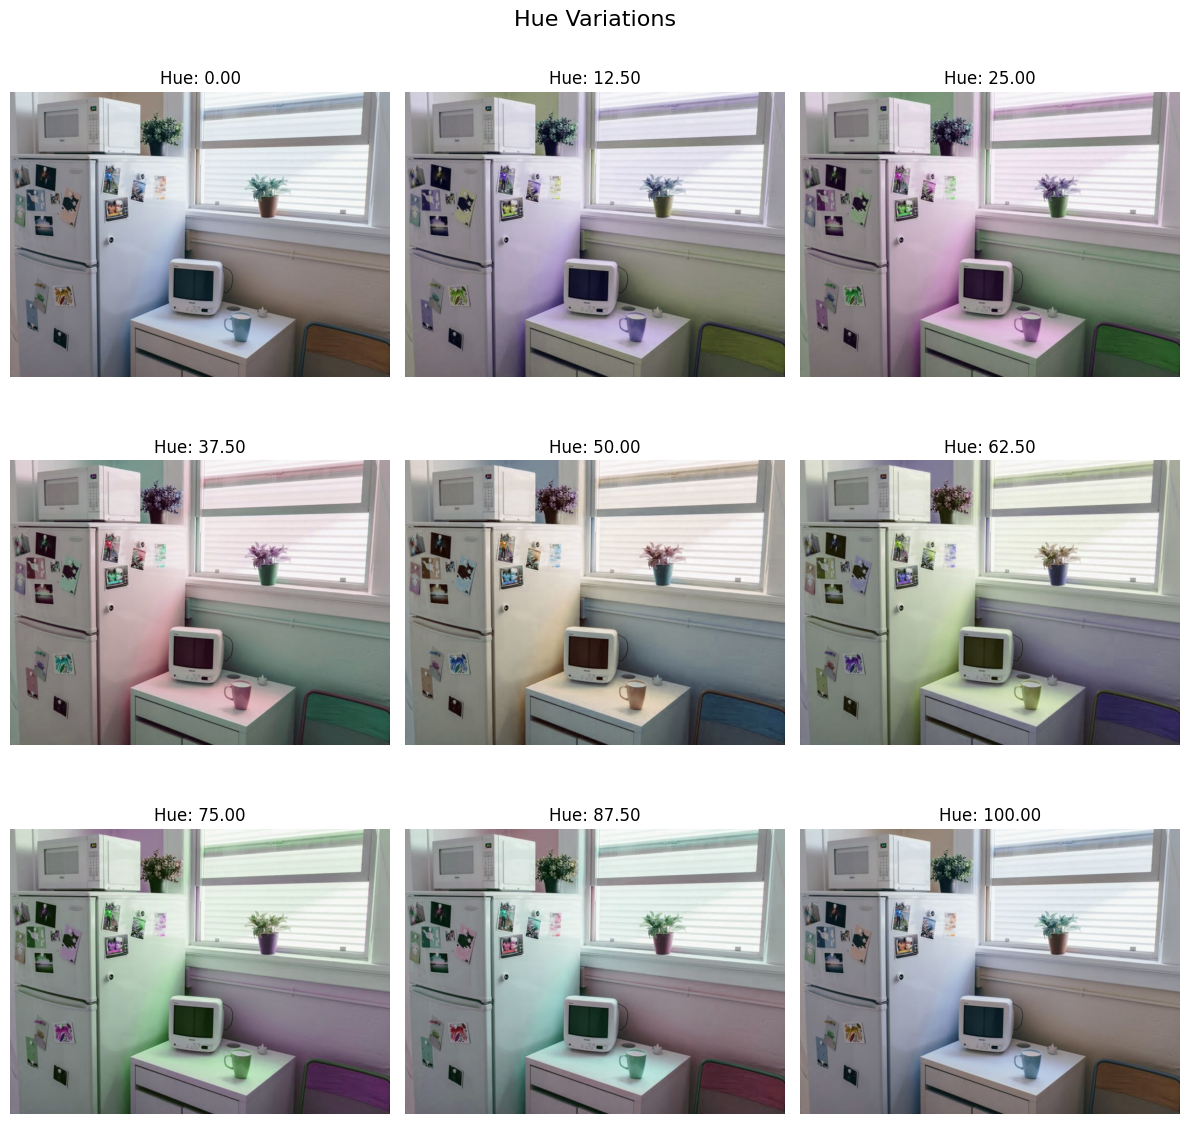

In [2]:
def plot_hue_variations(image_path, levels=9):
    # Create figure with 3x3 subplots
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.suptitle('Hue Variations', fontsize=16)
    
    # Load original image using FImage
    
    # Generate hue values from -1.0 to 1.0
    hue_values = np.linspace(0, 100.0, levels)
    
    # Plot each variation
    for idx, hue in enumerate(hue_values):
        row = idx // 3
        col = idx % 3
        
        # Create a copy and apply hue filter

        img = FImage(image_path)
        img.apply(Hue(hue))
        
        # Display the image
        axes[row, col].imshow(img.image)
        axes[row, col].axis('off')
        axes[row, col].set_title(f'Hue: {hue:.2f}')
    
    plt.tight_layout()
    plt.show()

# Example usage with your image path
img_path = "test_image.jpg"
plot_hue_variations(img_path)

### Loading Dataset

In [14]:
IMAGE_DIR = '../results/images'
METADATA_PATH = '../results/metadata.csv'
BATCH_SIZE = 16
NUM_FILTERS = 9  # Contrast, Brightness, Saturation, Hue, Exposure, Vibrance, Sepia, Sharpen, Noise
IMG_SIZE = (260, 260)

In [15]:
df = pd.read_csv(METADATA_PATH)
df.describe()

,Contrast,Brightness,Saturation,Hue,Exposure,Vibrance,Sepia,Sharpen,Noise
count,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000
mean,21.529293,8.662058,27.661111,24.785732,9.946970,30.118308,29.211995,21.111364,7.765025
std,25.234313,10.212089,33.192689,32.257784,10.847791,34.402591,33.864684,25.092842,9.848769
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.000000,0.000000,10.000000,0.000000,0.000000,0.000000,15.000000,0.000000,1.000000
75%,43.000000,17.000000,55.000000,49.000000,20.000000,60.000000,58.000000,42.000000,16.000000
max,75.000000,30.000000,100.000000,100.000000,30.000000,100.000000,100.000000,75.000000,30.000000


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [17]:
class FilterDataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None, normalize_intensities=True):
        self.df = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transform = transform
        self.filter_cols = self.df.columns.to_list()[1:]  
        self.normalize_intensities = normalize_intensities
        self.max_values = torch.tensor(list(map(lambda c: self.df[c].max(), self.filter_cols)))
        # TODO: if some filter is in negatives this breaks
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(os.path.join(self.image_dir, row['Id'])).convert("RGB")
        
        intensities = torch.tensor(row[self.filter_cols].values.astype(np.float32))
        
        if self.normalize_intensities:
            intensities = intensities / self.max_values
        
        if self.transform:
            image = self.transform(image)
        
        return image, intensities

In [18]:
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = FilterDataset(METADATA_PATH, IMAGE_DIR, transform=transform, normalize_intensities=True)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)


In [19]:
_, l = next(iter(train_loader))

### Model Architecture

In [24]:
class MultiOutputEfficientNet(nn.Module):
    def __init__(self, filter_names, num_filters=NUM_FILTERS, dropout_rate=0.3):
        super(MultiOutputEfficientNet, self).__init__()
        self.base_model = efficientnet_b2(weights=EfficientNet_B2_Weights.DEFAULT)

        in_features = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Identity()

        self.filter_names = filter_names
        
        self.filter_heads = nn.ModuleDict()
        for i in range(num_filters):
            self.filter_heads[self.filter_names[i]] = nn.Sequential(
                nn.Linear(in_features, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                
                nn.Linear(128, 64),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate * 0.5),
                
                nn.Linear(64, 1)
            )
    
    def forward(self, x):
        features = self.base_model(x)
        
        outputs = []
        for head in self.filter_heads.values():
            outputs.append(head(features))
        
        return torch.cat(outputs, dim=1)
      

filter_cols = df.columns.to_list()[1:]
model = MultiOutputEfficientNet(filter_cols)
model = model.to(device)

### Training 

In [25]:
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer)

In [26]:
# create checkpoint folder
from pathlib import Path

CHECKPOINT_FOLDER = Path("./checkpoints")
os.makedirs(CHECKPOINT_FOLDER, exist_ok=True)

In [27]:
train_losses = []
val_losses = []

for epoch in tqdm(range(10)):
    model.train()
    running_loss = 0.0
    last_loss = None

    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        last_loss = loss

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in test_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    # scheduler step
    scheduler.step(avg_val_loss)

    if epoch % 2 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': last_loss,
            'scheduler_state_dict': scheduler.state_dict()
        }, CHECKPOINT_FOLDER / f"checkpoint-{epoch}")

    print(f"Epoch [{epoch+1}/{10}]  Train Loss: {avg_train_loss:.4f}  Val Loss: {avg_val_loss:.4f}")

 10%|█         | 1/10 [01:44<15:42, 104.73s/it]

Epoch [1/10]  Train Loss: 0.0389  Val Loss: 0.0295


 20%|██        | 2/10 [03:25<13:41, 102.66s/it]

Epoch [2/10]  Train Loss: 0.0318  Val Loss: 0.0281


 30%|███       | 3/10 [05:07<11:55, 102.19s/it]

Epoch [3/10]  Train Loss: 0.0293  Val Loss: 0.0274


 40%|████      | 4/10 [06:48<10:09, 101.59s/it]

Epoch [4/10]  Train Loss: 0.0279  Val Loss: 0.0271


 50%|█████     | 5/10 [08:29<08:27, 101.59s/it]

Epoch [5/10]  Train Loss: 0.0265  Val Loss: 0.0261


 60%|██████    | 6/10 [10:10<06:45, 101.39s/it]

Epoch [6/10]  Train Loss: 0.0252  Val Loss: 0.0258


 70%|███████   | 7/10 [11:51<05:03, 101.31s/it]

Epoch [7/10]  Train Loss: 0.0237  Val Loss: 0.0271


 80%|████████  | 8/10 [13:31<03:21, 100.70s/it]

Epoch [8/10]  Train Loss: 0.0225  Val Loss: 0.0267


 90%|█████████ | 9/10 [15:12<01:40, 100.86s/it]

Epoch [9/10]  Train Loss: 0.0209  Val Loss: 0.0267


100%|██████████| 10/10 [16:54<00:00, 101.41s/it]

Epoch [10/10]  Train Loss: 0.0193  Val Loss: 0.0266


### Loss and Accuracy Plots

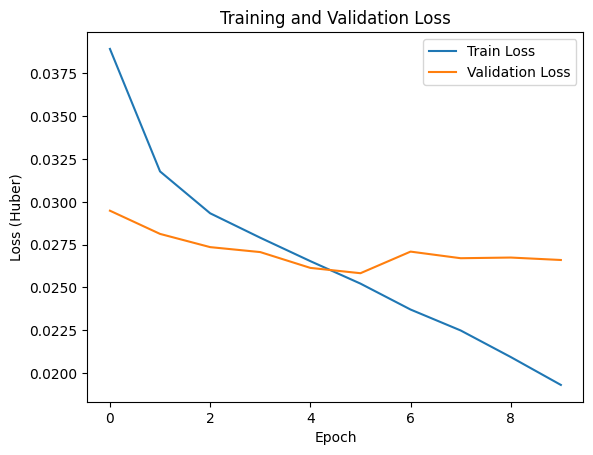

In [28]:
plt.title('Training and Validation Loss')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Huber)')
plt.legend()
plt.show()

In [29]:
torch.save(model.state_dict(), "../models/fildec.pt")

### Evaluation

In [39]:
def evaluate(model, dataloader):
    model.eval()
    all_preds, all_targets = [], [] 

    with torch.inference_mode():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            y_pred = model(inputs)

            all_preds.append(y_pred.cpu())
            all_targets.append(labels.cpu())


    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # 1) MSE per filter (vector of length 5) and overall
    mse_per_filter = mean_squared_error(all_targets, all_preds, multioutput='raw_values')
    mse_overall    = mean_squared_error(all_targets, all_preds, multioutput='uniform_average')

    # 2) RMSE (take sqrt of each MSE)
    rmse_per_filter = mse_per_filter ** 0.5
    rmse_overall    = mse_overall ** 0.5

    # 3) MAE per filter and overall
    mae_per_filter = mean_absolute_error(all_targets, all_preds, multioutput='raw_values')
    mae_overall    = mean_absolute_error(all_targets, all_preds, multioutput='uniform_average')

    # 4) R^2 per filter and overall (can also do multioutput='variance_weighted')
    r2_per_filter = []

    for i in range(all_targets.shape[1]):
        r2_per_filter.append(r2_score(all_targets[:, i], all_preds[:, i]))

    r2_overall = r2_score(all_targets, all_preds, multioutput='uniform_average')

    metrics = {
        "mse_per_filter":    mse_per_filter.tolist(),
        "mse_overall":       float(mse_overall),
        "rmse_per_filter":   rmse_per_filter.tolist(),
        "rmse_overall":      float(rmse_overall),
        "mae_per_filter":    mae_per_filter.tolist(),
        "mae_overall":       float(mae_overall),
        "r2_per_filter":     r2_per_filter,
        "r2_overall":        float(r2_overall),
    }
    return metrics

In [40]:
dataloaders = {
    "train": train_loader,
    "val": test_loader
}

In [ ]:
metrics = evaluate(model, test_loader)
metrics

{'mse_per_filter': [0.02460177056491375,
  0.027668647468090057,
  0.0943140983581543,
  0.04789005592465401,
  0.12851370871067047,
  0.1205650344491005,
  0.020460383966565132,
  0.022042104974389076,
  0.003039604052901268],
 'mse_overall': 0.05434393510222435,
 'rmse_per_filter': [0.15684951841831207,
  0.1663389503955841,
  0.30710601806640625,
  0.21883796155452728,
  0.3584880828857422,
  0.34722477197647095,
  0.1430397927761078,
  0.1484658420085907,
  0.055132605135440826],
 'rmse_overall': 0.23311785667817117,
 'mae_per_filter': [0.09712371975183487,
  0.10594291239976883,
  0.21974754333496094,
  0.09477155655622482,
  0.27189895510673523,
  0.26612183451652527,
  0.0866902768611908,
  0.09000540524721146,
  0.031048813834786415],
 'mae_overall': 0.14037233591079712,
 'r2_per_filter': [0.7851127982139587,
  0.7577676773071289,
  0.14611941576004028,
  0.5403668880462646,
  0.01476752758026123,
  -0.026216626167297363,
  0.8236356973648071,
  0.8048769235610962,
  0.97212457

In [42]:
uh = pd.read_csv(METADATA_PATH)
print(uh.head())

                   Id  Contrast  Brightness  Saturation  Hue  Exposure  \
0  arepas\0001_v1.jpg         0          22           0    0         0   
1  arepas\0001_v2.jpg        70           6          82   75        24   
2  arepas\0002_v1.jpg         0           0         100   32         0   
3  arepas\0002_v2.jpg        39           0           0    0        23   
4  arepas\0003_v1.jpg         0           8           0   73        22   

   Vibrance  Sepia  Sharpen  Noise  
0        64     96       74     28  
1        47      0        0      0  
2        61     43       24      0  
3        35      0       43     12  
4         0      0       64      0  


In [ ]:
filter_cols = uh.columns.to_list()[1:]
filter_cols

['Contrast',
 'Brightness',
 'Saturation',
 'Hue',
 'Exposure',
 'Vibrance',
 'Sepia',
 'Sharpen',
 'Noise']

In [45]:
metric_df = pd.DataFrame({"Filters": filter_cols, "MSE": metrics["mse_per_filter"], "MAE": metrics["mae_per_filter"], "RMSE": metrics["rmse_per_filter"], "R2": metrics["r2_per_filter"]})
metric_df

,Filters,MSE,MAE,RMSE,R2
0,Contrast,0.024602,0.097124,0.156850,0.785113
1,Brightness,0.027669,0.105943,0.166339,0.757768
2,Saturation,0.094314,0.219748,0.307106,0.146119
3,Hue,0.047890,0.094772,0.218838,0.540367
4,Exposure,0.128514,0.271899,0.358488,0.014768
5,Vibrance,0.120565,0.266122,0.347225,-0.026217
6,Sepia,0.020460,0.086690,0.143040,0.823636
7,Sharpen,0.022042,0.090005,0.148466,0.804877
8,Noise,0.003040,0.031049,0.055133,0.972125


In [46]:
maxes = list(map(lambda c: uh[c].max(), filter_cols))
maxes

[np.int64(75),
 np.int64(30),
 np.int64(100),
 np.int64(100),
 np.int64(30),
 np.int64(100),
 np.int64(100),
 np.int64(75),
 np.int64(30)]

In [47]:
def visualize_predictions(model, dataloader, idx):
    model.eval()

    with torch.inference_mode():
        inputs, targets = next(iter(dataloader))
        inputs, targets = inputs.to(device), targets.to(device)
        y_pred = model(inputs)

        first_prediction = y_pred[idx].cpu().numpy()
        first_target = targets[idx].cpu().numpy()

        for (pred, target, mx, f) in zip(first_prediction, first_target, maxes, filter_cols):
            scaled_pred = pred * mx
            scaled_target = target * mx

            print(f"Filter: {f}")
            print(f"Predicted filter: {scaled_pred:.4f}")
            print(f"Actual filter: {scaled_target:.4f}")
            print("----------------------")

        # TODO then apply the predicted filters to see how it worked

In [48]:
def infer_image(model, img_path, max_value=85.0):
    model.eval()

    transform = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.inference_mode():
        pred = model(input_tensor).squeeze(0).cpu().numpy()

    scaled_pred = pred * max_value
    filter_names = ['Contrast', 'Brightness', 'Saturation', 'Hue', 'Exposure', 'Vibrance', 'Sepia', 'Sharpen', 'Noise']

    print(f"Predicted filters for {os.path.basename(img_path)}:")
    for name, value in zip(filter_names, scaled_pred):
        print(f"{name}: {value:.2f}")

In [50]:
visualize_predictions(model, test_loader,2)

Filter: Contrast
Predicted filter: 0.0385
Actual filter: 0.0000
----------------------
Filter: Brightness
Predicted filter: 0.3333
Actual filter: 0.0000
----------------------
Filter: Saturation
Predicted filter: 45.2356
Actual filter: 41.0000
----------------------
Filter: Hue
Predicted filter: 0.4216
Actual filter: 0.0000
----------------------
Filter: Exposure
Predicted filter: 12.9390
Actual filter: 0.0000
----------------------
Filter: Vibrance
Predicted filter: 14.2591
Actual filter: 0.0000
----------------------
Filter: Sepia
Predicted filter: 0.2378
Actual filter: 0.0000
----------------------
Filter: Sharpen
Predicted filter: 0.0454
Actual filter: 0.0000
----------------------
Filter: Noise
Predicted filter: 23.6878
Actual filter: 24.0000
----------------------
